## Naive Bayes Classifier

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### About data

Источник данных: https://ai.stanford.edu/~amaas/data/sentiment/

Large Movie Review Dataset представляет собой набор данных, предназначенный для решения задачи бинарной классификации тональности текстов. Датасет содержит отзывы о фильмах, вручную аннотированные как положительные или отрицательные.

Структура набора данных включает две ключевые переменные:  
- label — метка класса, отражающая полярность отзыва (positive или negative);   
- review — текстовое содержимое отзыва.  

Задача: создать модель машинного обучения, которая на входе принимает текст отзыва, а на выходе определяет его тональность (положительная либо отрицательная).

In [2]:
df = pd.read_csv('D:/Machine Learning/Новая папка/_DATA/moviereviews.csv')

In [3]:
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


### Exploratory Data Analysis

В данных присутствуют пропущенные значения.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2000 non-null   object
 1   review  1965 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [5]:
df.isnull().sum()

label      0
review    35
dtype: int64

In [6]:
df = df.dropna()

В столбце review зафиксированы записи, не содержащие осмысленного текстового содержания. К ним относятся пустые строки (""), строки, состоящие исключительно из пробелов (" "), а также аналогичные варианты с отсутствием информативных символов. Указанные записи подлежат исключению из массива данных. 

In [7]:
# только для отзывов на английском языке
mask = ~df['review'].str.contains(r'[A-Za-z]', regex=True)
bad_rows = df[mask]
len(bad_rows)

27

In [8]:
df = df[df['review'].str.contains(r'[A-Za-zА-Яа-я]', regex=True)]

Распределение целевой переменной.

In [9]:
df['label'].value_counts()

neg    969
pos    969
Name: label, dtype: int64

Классы сбалансированны.

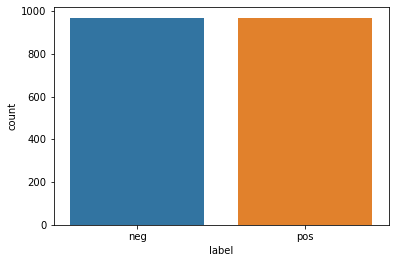

In [10]:
sns.countplot(data =df, x ='label');

С помощью модели CountVectorizer найти 20 наиболее часто встречающихся слов (которые не являются стоп-словами в английском языке), отдельно для каждого значения колонки label

In [11]:
# Векторизатор без стоп-слов
vectorizer = CountVectorizer(stop_words="english")

# Словарь для хранения результатов
top_words_by_label = {}

for label in df['label'].unique():
    # Фильтруем отзывы по классу
    texts = df.loc[df['label'] == label, 'review']
    
    # Векторизация только этого класса
    X = vectorizer.fit_transform(texts)
    
    # Считаем частоту слов
    word_counts = X.toarray().sum(axis=0)
    
    # Достаем список слов
    words = vectorizer.get_feature_names_out()
    
    # Складываем в DataFrame для удобства
    freq_df = pd.DataFrame({"word": words, "count": word_counts})
    
    # Берем топ-20 слов
    top20 = freq_df.sort_values(by="count", ascending=False).head(20)
    
    # Сохраняем в словарь: ключ = метка, значение = dict(слово: частота)
    top_words_by_label[label] = dict(zip(top20['word'], top20['count']))

Топ-20 слов для класса neg:

In [12]:
print(top_words_by_label['neg'])

{'film': 4063, 'movie': 3131, 'like': 1808, 'just': 1480, 'time': 1127, 'good': 1117, 'bad': 997, 'character': 926, 'story': 908, 'plot': 888, 'characters': 838, 'make': 813, 'really': 743, 'way': 734, 'little': 696, 'don': 683, 'does': 666, 'doesn': 648, 'action': 635, 'scene': 634}


Топ-20 слов для класса pos:

In [13]:
print(top_words_by_label['pos'])

{'film': 5002, 'movie': 2389, 'like': 1721, 'just': 1273, 'story': 1199, 'good': 1193, 'time': 1175, 'character': 1037, 'life': 1032, 'characters': 957, 'way': 864, 'films': 851, 'does': 828, 'best': 788, 'people': 769, 'make': 764, 'little': 751, 'really': 731, 'man': 728, 'new': 702}


## Model

In [14]:
# Данные
X = df['review']
le = LabelEncoder()
y = le.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101
)

# Пайплайн
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

param_grid = {
    # TfidfVectorizer
    'tfidf__ngram_range': [(1,1), (1,2)],     # униграммы и биграммы
    'tfidf__max_df': [0.9, 1.0],              # исключаем слишком частые слова
    'tfidf__min_df': [2, 5],                  # исключаем редкие слова
    'tfidf__max_features': [10000, 20000],     # ограничим размер словаря 

    # MultinomialNB
    'nb__alpha': [0.1, 0.5, 1.0],             # сглаживание
    'nb__fit_prior': [True, False]            # использовать априорные вероятности
}

# GridSearchCV
nb_classifier = GridSearchCV(
    pipe_nb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Обучение
nb_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.1, 0.5, 1.0],
                         'nb__fit_prior': [True, False],
                         'tfidf__max_df': [0.9, 1.0],
                         'tfidf__max_features': [10000, 20000],
                         'tfidf__min_df': [2, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=2)

## Model Evaluation

- classification_report  
- confusion_matrix  

In [15]:
predictions_nb = nb_classifier.predict(X_test)
print(classification_report(y_test,predictions_nb, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.82      0.86      0.84       191
         pos       0.86      0.81      0.83       197

    accuracy                           0.84       388
   macro avg       0.84      0.84      0.84       388
weighted avg       0.84      0.84      0.84       388



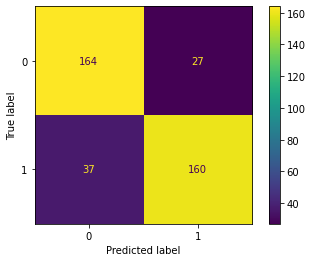

In [16]:
cm_nb = confusion_matrix(y_test, predictions_nb, labels=nb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb_classifier.classes_)
disp.plot()
plt.show()

Модель Multinomial Naive Bayes показала хорошие результаты:  

- Accuracy: 84% — 8 из 10 отзывов классифицируются верно.  
  
- Баланс по классам: precision и recall находятся в районе 0.82–0.86, что говорит об устойчивой работе без явного перекоса. 
- Качество классификации достаточно для базового решения, с учетом простоты и скорости работы алгоритма.  